# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

     |████████████████████████████████| 78 kB 3.1 MB/s 
     |████████████████████████████████| 462 kB 10.7 MB/s 
  Created wheel for adapt: filename=adapt-0.4.0-py3-none-any.whl size=101264 sha256=e189a9d2158423ebc3bfce816af71cb03a26d8bbbd5590dd97fc2503bdb6c910
  Stored in directory: /root/.cache/pip/wheels/47/47/61/e923985c37a7075ec75c4b16295782354b1c5dd291d47a7637
Successfully built adapt


In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_128_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_128_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_128_train3.pkl"
Source_dir_train4 = "./Images/DANN/Source/LC25000_mix_data_128_train4.pkl"
Source_dir_train5 = "./Images/DANN/Source/LC25000_mix_data_128_train5.pkl"
Source_dir_test1 = "./Images/DANN/Source/LC25000_mix_data_128_test1.pkl"
Source_dir_test2 = "./Images/DANN/Source/LC25000_mix_data_128_test2.pkl"


Target_dir_train = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_train.pkl")
Target_dir_test = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_test.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_train.pkl")
Target_cyclegan_dir_test = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_test.pkl")

In [ ]:
BATCH_SIZE = 64
CHANNELS = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCH = 5

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)
with open(os.path.abspath(Source_dir_train4), "rb") as f:
    LC25000_train4 = pickle.load(f)
with open(os.path.abspath(Source_dir_train5), "rb") as f:
    LC25000_train5 = pickle.load(f)
with open(os.path.abspath(Source_dir_test1), "rb") as f:
    LC25000_test1 = pickle.load(f)
with open(os.path.abspath(Source_dir_test2), "rb") as f:
    LC25000_test2 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] + LC25000_train4['train'] + LC25000_train5['train']
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label'],LC25000_train4['train_label'],LC25000_train5['train_label']))
LC25000_test_data = LC25000_test1['test'] + LC25000_test2['test']
LC25000_test_labels = np.concatenate((LC25000_test1['test_label'],LC25000_test2['test_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)
LC25000_test_lab = tf.one_hot(LC25000_test_labels, depth=3)

In [ ]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)
LC25000_test_data = np.array(LC25000_test_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))
print("The shape of LC25000_test_data: ", np.shape(LC25000_test_data))
print("The shape of LC25000_test_labels: " ,np.shape(LC25000_test_labels))

The shape of LC25000_train_data:  (6400, 128, 128, 3)
The shape of LC25000_train_labels:  (6400,)
The shape of LC25000_test_data:  (1600, 128, 128, 3)
The shape of LC25000_test_labels:  (1600,)


In [ ]:
import gc
gc.collect()

272

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train), "rb") as f:
    TCGA_train = pickle.load(f)
with open(os.path.abspath(Target_dir_test), "rb") as f:
    TCGA_test = pickle.load(f)

In [ ]:
TCGA_train_data = TCGA_train['train']
TCGA_train_labels = TCGA_train['train_label']
TCGA_test_data = TCGA_test['test']
TCGA_test_labels = TCGA_test['test_label']

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)

In [ ]:
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (6400, 128, 128, 3)
The shape of TCGA_train_labels:  (6400,)
The shape of TCGA_test_data:  (6400, 128, 128, 3)
The shape of TCGA_test_labels:  (6400,)


In [ ]:
import gc
gc.collect()

253

## Datasets Visualization

<function matplotlib.pyplot.show>

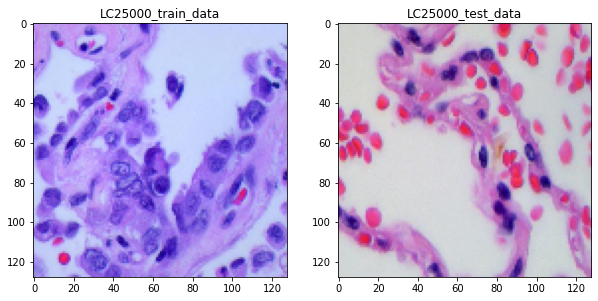

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_test_data)
img2 = array_to_img(sample2)
plt.title("LC25000_test_data")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

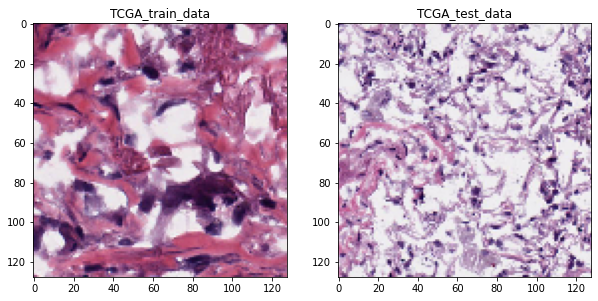

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_test_data")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_128.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_128.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 4, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))

# one = OneHotEncoder(sparse=False)
# one.fit(np.array(LC25000_train_labels).reshape(-1, 1))

# LC25000_train_lab = one.transform(np.array(LC25000_train_labels).reshape(-1, 1))
# TCGA_train_lab = one.transform(np.array(TCGA_train_labels).reshape(-1, 1))

print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data (source) shape: (6400, 128, 128, 3)
TCGA_train_data (target) shape: (6400, 128, 128, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig_5 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig_5 .fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
100/100 [==============================] - 2s 23ms/step - loss: 0.2328 - acc: 0.9145 - val_loss: 1.9530 - val_acc: 0.4367
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 0.2252 - acc: 0.9112 - val_loss: 2.0024 - val_acc: 0.4309
Epoch 3/100
100/100 [==============================] - 2s 24ms/step - loss: 0.2139 - acc: 0.9175 - val_loss: 2.0549 - val_acc: 0.4283
Epoch 4/100
100/100 [==============================] - 2s 23ms/step - loss: 0.2064 - acc: 0.9194 - val_loss: 2.0677 - val_acc: 0.4325
Epoch 5/100
100/100 [==============================] - 3s 25ms/step - loss: 0.2007 - acc: 0.9198 - val_loss: 2.0953 - val_acc: 0.4322
Epoch 6/100
100/100 [==============================] - 2s 23ms/step - loss: 0.1967 - acc: 0.9231 - val_loss: 2.1221 - val_acc: 0.4302
Epoch 7/100
100/100 [==============================] - 3s 30ms/step - loss: 0.1925 - acc: 0.9234 - val_loss: 2.1659 - val_acc: 0.4277
Epoch 8/100
100/100 [==============================] - 3s 26ms

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig_5 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig_5 .fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 4s 24ms/step - loss: 0.7580 - acc: 0.7233 - val_loss: 1.4735 - val_acc: 0.4975
Epoch 2/5
100/100 [==============================] - 2s 19ms/step - loss: 0.4076 - acc: 0.8219 - val_loss: 1.6587 - val_acc: 0.4659
Epoch 3/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2770 - acc: 0.8889 - val_loss: 1.8162 - val_acc: 0.4580
Epoch 4/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2361 - acc: 0.9083 - val_loss: 1.9193 - val_acc: 0.4595
Epoch 5/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2023 - acc: 0.9212 - val_loss: 2.0421 - val_acc: 0.4683
Epoch 1/100
100/100 [==============================] - 5s 30ms/step - loss: 0.1853 - acc: 0.9298 - val_loss: 1.9226 - val_acc: 0.4667
Epoch 2/100
100/100 [==============================] - 2s 23ms/step - loss: 0.1622 - acc: 0.9416 - val_loss: 2.0755 - val_acc: 0.4787
Epoch 3/100
100/100 [==============================] - 2s 23ms/step - lo

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig_5 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig_5 .fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 4s 25ms/step - loss: 0.7461 - acc: 0.7230 - val_loss: 1.4438 - val_acc: 0.4798
Epoch 2/5
100/100 [==============================] - 2s 19ms/step - loss: 0.3909 - acc: 0.8345 - val_loss: 1.6463 - val_acc: 0.4345
Epoch 3/5
100/100 [==============================] - 2s 17ms/step - loss: 0.2689 - acc: 0.8977 - val_loss: 1.8625 - val_acc: 0.4277
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.2179 - acc: 0.9175 - val_loss: 2.0199 - val_acc: 0.4300
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.2009 - acc: 0.9228 - val_loss: 2.1097 - val_acc: 0.4405
Epoch 1/100
100/100 [==============================] - 5s 29ms/step - loss: 0.1757 - acc: 0.9369 - val_loss: 2.0448 - val_acc: 0.4477
Epoch 2/100
100/100 [==============================] - 2s 23ms/step - loss: 0.1685 - acc: 0.9378 - val_loss: 2.1462 - val_acc: 0.4567
Epoch 3/100
100/100 [==============================] - 2s 23ms/step - lo

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig_5 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig_5 .fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 24ms/step - loss: 0.7891 - acc: 0.7064 - val_loss: 1.4662 - val_acc: 0.4902
Epoch 2/5
100/100 [==============================] - 2s 19ms/step - loss: 0.4084 - acc: 0.8275 - val_loss: 1.6998 - val_acc: 0.4286
Epoch 3/5
100/100 [==============================] - 2s 18ms/step - loss: 0.2797 - acc: 0.8867 - val_loss: 1.8960 - val_acc: 0.4223
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.2235 - acc: 0.9153 - val_loss: 2.0032 - val_acc: 0.4423
Epoch 5/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2033 - acc: 0.9219 - val_loss: 2.1441 - val_acc: 0.4408
Epoch 1/100
100/100 [==============================] - 4s 33ms/step - loss: 0.1938 - acc: 0.9305 - val_loss: 2.1288 - val_acc: 0.4591
Epoch 2/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1726 - acc: 0.9377 - val_loss: 2.1384 - val_acc: 0.4630
Epoch 3/100
100/100 [==============================] - 3s 26ms/step - lo

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig_5 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig_5 .fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 4s 24ms/step - loss: 0.7580 - acc: 0.7262 - val_loss: 1.4605 - val_acc: 0.4834
Epoch 2/5
100/100 [==============================] - 2s 19ms/step - loss: 0.4154 - acc: 0.8184 - val_loss: 1.6888 - val_acc: 0.4263
Epoch 3/5
100/100 [==============================] - 2s 19ms/step - loss: 0.2850 - acc: 0.8798 - val_loss: 1.8071 - val_acc: 0.4383
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.2269 - acc: 0.9123 - val_loss: 1.9980 - val_acc: 0.4238
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.1953 - acc: 0.9264 - val_loss: 2.0590 - val_acc: 0.4383
Epoch 1/100
100/100 [==============================] - 4s 28ms/step - loss: 0.1852 - acc: 0.9322 - val_loss: 2.1281 - val_acc: 0.4291
Epoch 2/100
100/100 [==============================] - 2s 23ms/step - loss: 0.1752 - acc: 0.9364 - val_loss: 2.0547 - val_acc: 0.4384
Epoch 3/100
100/100 [==============================] - 2s 24ms/step - lo

### Result

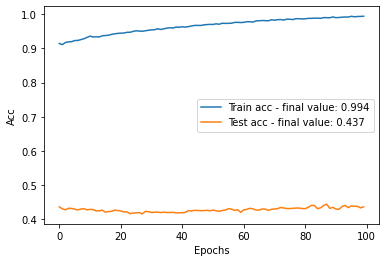

In [ ]:
acc = finetunig_5.history.history["acc"]; val_acc = finetunig_5.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


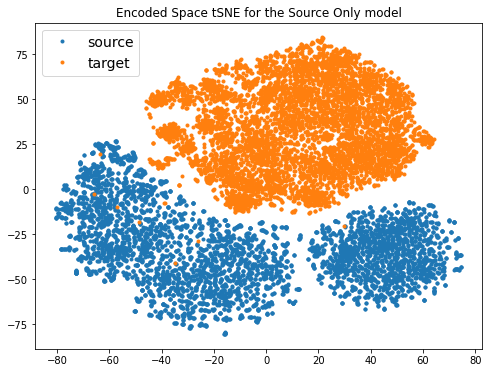

In [ ]:
LC25000_train_data_enc = finetunig_5.transform(LC25000_train_data_ex)
TCGA_train_data_enc = finetunig_5.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig_5.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.090635,0.965373,3.198967,0.428308
std,0.056108,0.022541,0.789526,0.006135
min,0.020261,0.911250,1.953022,0.416094
25%,0.042011,0.950195,2.556899,0.423594
50%,0.078958,0.970313,3.073693,0.427969
75%,0.129968,0.984727,3.777597,0.431953
max,0.232816,0.994219,4.780887,0.444531


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_source_Resnet_RMS_0.5e-5.csv")

# Fit with adaptation

### Run 1


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
100/100 [==============================] - 8s 41ms/step - loss: 0.7917 - acc: 0.7013 - disc_loss: 1.5349 - val_loss: 1.0799 - val_acc: 0.4933
Epoch 2/100
100/100 [==============================] - 4s 35ms/step - loss: 0.3592 - acc: 0.8594 - disc_loss: 1.4092 - val_loss: 1.2747 - val_acc: 0.4700
Epoch 3/100
100/100 [==============================] - 4s 35ms/step - loss: 0.2815 - acc: 0.8897 - disc_loss: 1.2804 - val_loss: 1.3578 - val_acc: 0.4661
Epoch 4/100
100/100 [==============================] - 4s 37ms/step - loss: 0.2243 - acc: 0.9162 - disc_loss: 1.1403 - val_loss: 1.3787 - val_acc: 0.4803
Epoch 5/100
100/100 [==============================] - 4s 35ms/step - loss: 0.1938 - acc: 0.9280 - disc_loss: 1.0258 - val_loss: 1.4379 - val_acc: 0.4811
Epoch 6/100
100/100 [==============================] - 4s 35ms/step - loss: 0.1768 - acc: 0.9319 - disc_loss: 0.9357 - val_loss: 1.5785 - val_acc: 0.4808
Epoch 7/100
100/100 [==============================] - 4s 35ms/step - loss: 

### Run 2


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 40ms/step - loss: 0.0557 - acc: 0.9831 - disc_loss: 11.8411 - val_loss: 15.8533 - val_acc: 0.4923
Epoch 2/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0990 - acc: 0.9742 - disc_loss: 13.9749 - val_loss: 23.0203 - val_acc: 0.4934
Epoch 3/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0894 - acc: 0.9737 - disc_loss: 14.6194 - val_loss: 29.5875 - val_acc: 0.4983
Epoch 4/200
100/100 [==============================] - 4s 35ms/step - loss: 0.1061 - acc: 0.9712 - disc_loss: 14.9096 - val_loss: 32.4380 - val_acc: 0.4995
Epoch 5/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0968 - acc: 0.9722 - disc_loss: 15.1765 - val_loss: 34.2886 - val_acc: 0.5000
Epoch 6/200
100/100 [==============================] - 4s 35ms/step - loss: 0.1000 - acc: 0.9702 - disc_loss: 15.1736 - val_loss: 34.7541 - val_acc: 0.5000
Epoch 7/200
100/100 [==============================] - 4s 35ms/s

### Run 3


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
100/100 [==============================] - 7s 39ms/step - loss: 0.8351 - acc: 0.6636 - disc_loss: 1.5421 - val_loss: 1.0612 - val_acc: 0.4961
Epoch 2/100
100/100 [==============================] - 4s 35ms/step - loss: 0.3652 - acc: 0.8575 - disc_loss: 1.4273 - val_loss: 1.2589 - val_acc: 0.4627
Epoch 3/100
100/100 [==============================] - 4s 35ms/step - loss: 0.2515 - acc: 0.9013 - disc_loss: 1.2923 - val_loss: 1.3623 - val_acc: 0.4614
Epoch 4/100
100/100 [==============================] - 4s 35ms/step - loss: 0.2139 - acc: 0.9162 - disc_loss: 1.1739 - val_loss: 1.4193 - val_acc: 0.4775
Epoch 5/100
100/100 [==============================] - 4s 35ms/step - loss: 0.1914 - acc: 0.9305 - disc_loss: 1.0636 - val_loss: 1.4224 - val_acc: 0.4883
Epoch 6/100
100/100 [==============================] - 4s 36ms/step - loss: 0.1721 - acc: 0.9375 - disc_loss: 0.9597 - val_loss: 1.4878 - val_acc: 0.4905
Epoch 7/100
100/100 [==============================] - 3s 35ms/step - loss: 

### Run 4


In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
100/100 [==============================] - 4s 38ms/step - loss: 0.1464 - acc: 0.9567 - disc_loss: 10.8892 - val_loss: 2.7575 - val_acc: 0.4863
Epoch 2/100
100/100 [==============================] - 4s 35ms/step - loss: 0.1134 - acc: 0.9634 - disc_loss: 10.3553 - val_loss: 2.6628 - val_acc: 0.4828
Epoch 3/100
100/100 [==============================] - 4s 36ms/step - loss: 0.1468 - acc: 0.9614 - disc_loss: 10.5897 - val_loss: 2.5530 - val_acc: 0.4861
Epoch 4/100
100/100 [==============================] - 4s 36ms/step - loss: 0.0994 - acc: 0.9695 - disc_loss: 10.5112 - val_loss: 4.1608 - val_acc: 0.4833
Epoch 5/100
100/100 [==============================] - 4s 35ms/step - loss: 0.0916 - acc: 0.9727 - disc_loss: 10.5626 - val_loss: 3.4185 - val_acc: 0.4853
Epoch 6/100
100/100 [==============================] - 4s 35ms/step - loss: 0.1366 - acc: 0.9623 - disc_loss: 11.0662 - val_loss: 3.5927 - val_acc: 0.4837
Epoch 7/100
100/100 [==============================] - 4s 36ms/step - 

### Run 5


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
100/100 [==============================] - 7s 41ms/step - loss: 0.0881 - acc: 0.9781 - disc_loss: 4.3857 - val_loss: 2.6999 - val_acc: 0.4883
Epoch 2/100
100/100 [==============================] - 4s 36ms/step - loss: 0.0924 - acc: 0.9767 - disc_loss: 1.7583 - val_loss: 1.9344 - val_acc: 0.4861
Epoch 3/100
100/100 [==============================] - 4s 36ms/step - loss: 0.1016 - acc: 0.9748 - disc_loss: 1.4579 - val_loss: 2.8294 - val_acc: 0.4905
Epoch 4/100
100/100 [==============================] - 3s 35ms/step - loss: 0.0960 - acc: 0.9786 - disc_loss: 1.3884 - val_loss: 4.4544 - val_acc: 0.4897
Epoch 5/100
100/100 [==============================] - 3s 35ms/step - loss: 0.1281 - acc: 0.9767 - disc_loss: 1.3722 - val_loss: 6.7264 - val_acc: 0.4894
Epoch 6/100
100/100 [==============================] - 3s 35ms/step - loss: 0.0777 - acc: 0.9812 - disc_loss: 1.3220 - val_loss: 4.5076 - val_acc: 0.4878
Epoch 7/100
100/100 [==============================] - 3s 35ms/step - loss: 

### Result

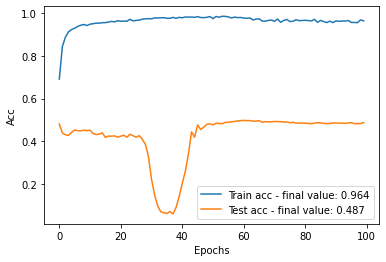

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


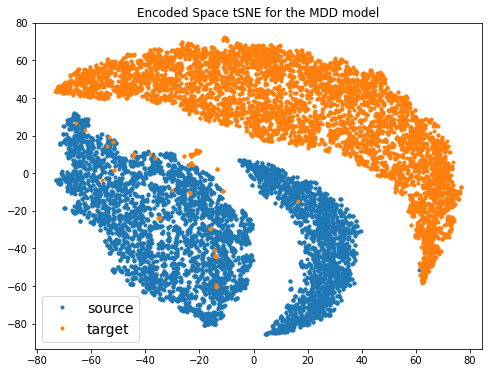

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.111935,0.962063,4.948920,8.625011,0.423016
std,0.088127,0.033624,4.597228,6.946100,0.118029
min,0.033575,0.691406,0.509700,1.140086,0.059219
25%,0.062563,0.960430,0.913704,2.190247,0.425469
50%,0.099312,0.966250,2.049328,6.488182,0.481250
75%,0.130444,0.977578,9.752362,15.332049,0.486758
max,0.805758,0.985781,13.408403,23.718464,0.497344


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD/MDD_Resnet_RMS_0.5e-5_g1.csv")

In [ ]:
import gc
gc.collect()